In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [2]:
import geopandas as gpd

In [3]:
gdf=gpd.read_file("../input/third/ZIP/")

In [4]:
gdf.shape

(33144, 10)

In [20]:
(gdf.GEOID10==gdf.ZCTA5CE10).all()

True

In [22]:
gdf['zip3']=gdf.ZCTA5CE10.map(lambda u: u[:3])

In [45]:
gdf['x']=gdf['geometry'].map(lambda u: u.centroid.x)
gdf['y']=gdf['geometry'].map(lambda u: u.centroid.y)

In [47]:
gdf.head()

ZCTA5CE10 GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10    ALAND10  AWATER10  \
0     43451   43451        B5   G6350          S   63411475    157689   
1     43452   43452        B5   G6350          S  121783674  13437380   
2     43456   43456        B5   G6350          S    9389362    999166   
3     43457   43457        B5   G6350          S   48035540         0   
4     43458   43458        B5   G6350          S    2573816     39915   

    INTPTLAT10    INTPTLON10  \
0  +41.3183010  -083.6174935   
1  +41.5157923  -082.9809454   
2  +41.6468445  -082.8226641   
3  +41.2673266  -083.4274645   
4  +41.5304461  -083.2133648   

                                            geometry zip3          x  \
0  POLYGON ((-83.708733 41.327326, -83.708147 41....  434 -83.615114   
1  POLYGON ((-83.086978 41.537796, -83.0825629999...  434 -82.966798   
2  (POLYGON ((-82.835577 41.710823, -82.83515 41....  434 -82.822940   
3  POLYGON ((-83.49650299999999 41.253708, -83.48...  434 -83.427461   
4  POLYGON ((-83.222292 41.531025, -83.2222819999...  434 -83.212587   

           y  
0  41.312799  
1  41.515178  
2  41.668431  
3  41.267326  
4  41.531051

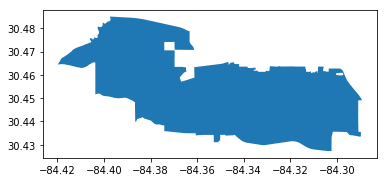

In [49]:
gdf[gdf.GEOID10=='32304'].plot()

In [43]:
def f(df):
    lst=df['geometry'].values
    return reduce(lambda u,v: u.union(v), lst)
#zip3gdf=gdf[['zip3','geometry']].groupby("zip3").apply(f)

In [53]:
blocks=dd.read_parquet("../input/info/censusblockinfo.parq").compute()

In [57]:
print blocks.shape
blocks.head()

(1930652, 6)


state state_county rawcensustractandblock          area  centroid_x  \
index                                                                       
0        19        19001        190019602001192  6.558681e-05  -94.407532   
1        19        19001        190019602001051  2.786426e-04  -94.424183   
2        19        19001        190019602001050  4.743040e-07  -94.414111   
3        19        19001        190019603002004  2.717475e-07  -94.454585   
4        19        19001        190019602001067  2.770656e-04  -94.405060   

       centroid_y  
index              
0       41.285108  
1       41.308993  
2       41.303880  
3       41.318615  
4       41.265556

In [55]:
from scipy.spatial import cKDTree

In [64]:
a=blocks.iloc[:100][['centroid_x','centroid_y']].values

In [59]:
tree = cKDTree(gdf[[ 'x', 'y']].values)

In [67]:
gdf.columns

Index([ u'ZCTA5CE10',    u'GEOID10',  u'CLASSFP10',    u'MTFCC10',
       u'FUNCSTAT10',    u'ALAND10',   u'AWATER10', u'INTPTLAT10',
       u'INTPTLON10',   u'geometry',       u'zip3',          u'x',
                u'y'],
      dtype='object')

In [163]:
def query(xy,n=5):
    distance, ii = tree.query(xy,n)
    zipcodes=gdf.iloc[ii.reshape(-1),0].values.reshape(ii.shape)
    return distance ,zipcodes

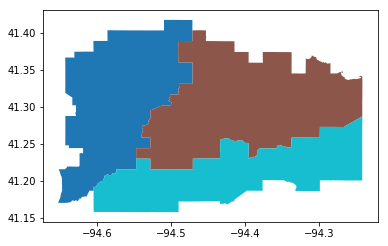

In [88]:
gdf[gdf.GEOID10.isin(set([u'50849', u'50858', u'50846' ]))].plot(column="GEOID10")

In [90]:
points=blocks[['centroid_x','centroid_y']].values

In [97]:
%time distances, zips=query(points)

CPU times: user 2.44 s, sys: 28 ms, total: 2.47 s
Wall time: 2.47 s


In [99]:
zips.shape

(1930652, 5)

In [100]:
zips[0]

array([u'50849', u'50858', u'50846', u'50801', u'50250'], dtype=object)

In [103]:
pd.Series([len(set([u[:3] for u in v])) for v in zips]).value_counts()

1    975357
2    757543
3    182496
4     14878
5       378
dtype: int64

In [107]:
geodict=dict(gdf[[u'ZCTA5CE10',u'geometry']].values)

In [116]:
points[i]

array([-94.40753233,  41.28510755])

In [117]:
type(geodict[code])

shapely.geometry.polygon.Polygon

In [121]:
from shapely.geometry import Point

In [122]:
geodict[code].contains(Point(points[i]))

True

In [155]:
assert len(zips)==len(points)

In [157]:
%%time
lst=[]
for i in range(len(zips)):
    if 1:
        p=Point(points[i])
        bfind=False
        for code in zips[i]:
            if geodict[code].contains(p):
                lst.append(code)
                bfind=True
                break
        if not bfind:
            lst.append(None)
    if i%10000==0:
        print i,

0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 230000 240000 250000 260000 270000 280000 290000 300000 310000 320000 330000 340000 350000 360000 370000 380000 390000 400000 410000 420000 430000 440000 450000 460000 470000 480000 490000 500000 510000 520000 530000 540000 550000 560000 570000 580000 590000 600000 610000 620000 630000 640000 650000 660000 670000 680000 690000 700000 710000 720000 730000 740000 750000 760000 770000 780000 790000 800000 810000 820000 830000 840000 850000 860000 870000 880000 890000 900000 910000 920000 930000 940000 950000 960000 970000 980000 990000 1000000 1010000 1020000 1030000 1040000 1050000 1060000 1070000 1080000 1090000 1100000 1110000 1120000 1130000 1140000 1150000 1160000 1170000 1180000 1190000 1200000 1210000 1220000 1230000 1240000 1250000 1260000 1270000 1280000 1290000 1300000 1310000 1320000 1330000 1340000 1350000 1360000 1370000 1380000 13

In [158]:
assert len(zips)==len(lst), len(lst)

In [159]:
np.sum([u is None for u in lst])

110881

In [160]:
np.where(np.array([u is None for u in lst]))

(array([    564,     846,    1774, ..., 1930556, 1930601, 1930602]),)

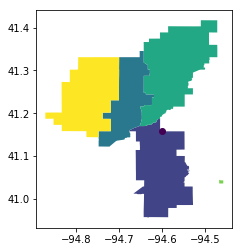

In [161]:
 gpd.GeoDataFrame([[k,geodict[v]] for k,v in enumerate(zips[564])] 
               + [[-1,Point(points[564])]],columns=['a','geometry']).plot(column='a')

In [162]:
for i in [564]:
    print i, [geodict[v].contains(Point(points[i])) for k,v in enumerate(zips[i])]

564 [False, False, False, False, False]


In [170]:
 for i in range(len(lst)):
    if i%100000==0:
        print i,
    if lst[i] is None:
        _, this_zip=query(points[i],n=10)
        p=Point(points[i])
        bfind=False
        for code in this_zip:
            if geodict[code].contains(p):
                #lst.append(code)
                lst[i]=code
                bfind=True
                break

0 100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 1800000 1900000


In [171]:
assert len(zips)==len(lst), len(lst)

In [172]:
np.sum([u is None for u in lst])

65457

In [186]:
for i in range(len(lst)):
    if lst[i] is None:
        lst[i]=zips[i][0]


In [187]:
assert len(zips)==len(lst), len(lst)

In [189]:
assert np.sum([u is None for u in lst])==0

In [190]:
lst[:3]

[u'50849', u'50849', u'50849']

In [193]:
set([len(u) for u in lst])

{5}

In [199]:
blocks['zip']=lst
blocks['zip3']=blocks['zip'].map(lambda u: u[:3])

In [200]:
blocks.head()

state state_county rawcensustractandblock          area  centroid_x  \
index                                                                       
0        19        19001        190019602001192  6.558681e-05  -94.407532   
1        19        19001        190019602001051  2.786426e-04  -94.424183   
2        19        19001        190019602001050  4.743040e-07  -94.414111   
3        19        19001        190019603002004  2.717475e-07  -94.454585   
4        19        19001        190019602001067  2.770656e-04  -94.405060   

       centroid_y    zip zip3  
index                          
0       41.285108  50849  508  
1       41.308993  50849  508  
2       41.303880  50849  508  
3       41.318615  50849  508  
4       41.265556  50849  508

In [203]:
blocks.zip3.value_counts().shape

(230,)

In [204]:
fastparquet.write("../input/info/censusblockinfo_withzip.parq",blocks,compression='SNAPPY')

In [185]:
for i in [3119]:
    print i, [geodict[v].contains(Point(points[i])) for k,v in enumerate(query(points[i],n=30)[1])]

3119 [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


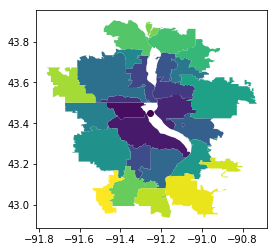

In [184]:
 gpd.GeoDataFrame([[k,geodict[v]] for k,v in enumerate(query(points[i],n=30)[1])] 
               + [[-1,Point(points[i])]],columns=['a','geometry']).plot(column='a')